<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_RPCA_with_prox_backward_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla P100-PCIE-16GB
0
0


# L1 and nuclear loss functions with backward by prox (soft thresholding and singular value thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Robust PCA (Low-rank and sparse matrix approximation): $$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda_S \|S\|_1+\lambda_F\|D-(L+S)\|_F^2$$
### Auto differentiation vs. proximal operation



In [3]:
# generate a low-rank matrix L and a sparse matrix S
from time import time
import numpy as np
m, n = 10000, 50
rnk, nnz = 10, 10000
LL = np.random.randn(m,rnk).dot(np.random.randn(rnk,n))
SS = np.zeros((m,n))
support = np.random.choice(m*n, nnz, replace=False)
SS.ravel()[support] = 10.* np.random.randn(support.size)

sv = np.linalg.svd(LL, compute_uv=False)
print('singular values of L =')
print(sv[:min(10,m,n)])
print('mean(abs(L)) = %.2e' % (np.mean(np.abs(LL))))
print('mean(abs(S)) = %.2e, %d nonzeros in S (%2.1f%%)' % (np.mean(np.abs(SS)),support.size,100.*support.size/(m*n)))

DD = LL + SS

ll = 1./np.sqrt(max(m,n))
print('lambda_S = ', ll)

singular values of L =
[915.12082481 830.9768783  814.34673506 787.31777991 684.50307946
 644.61600202 631.21207499 539.67627463 496.6614565  476.72787807]
mean(abs(L)) = 2.45e+00
mean(abs(S)) = 1.60e-01, 10000 nonzeros in S (2.0%)
lambda_S =  0.01


## ADMM-type (Inexact ALM) application of backward by prox
### less estimation error, can clearly identify the sparse components

D = 
 tensor([[ 0.0778,  1.9967,  2.5257,  ..., -2.6431,  1.9587,  1.0445],
        [ 0.2846,  4.9043,  1.6836,  ...,  0.0712, 10.0185,  2.2327],
        [ 0.9717, -2.8738, -2.6559,  ...,  4.7797, -3.2285,  3.4228],
        ...,
        [ 0.2105, -1.9287, -0.9627,  ..., -0.7004,  1.8635, -0.8568],
        [ 2.3281,  3.5614, -1.7199,  ..., -1.1316, -1.2095, -2.3871],
        [ 3.9198,  0.2734, -4.2799,  ...,  2.3160, -0.5853,  0.8559]],
       device='cuda:0')
lambda_F =  1000000.0
[ 40/400]: loss = 11537.2168,  
[ 80/400]: loss = 10472.7217,  
[120/400]: loss = 9453.9629,  
[160/400]: loss = 8506.1719,  
[200/400]: loss = 7798.9785,  
[240/400]: loss = 7667.9219,  
[280/400]: loss = 7644.3257,  
[320/400]: loss = 7633.4829,  
[360/400]: loss = 7627.7930,  
[400/400]: loss = 7624.6235,  
9863.191843032837  [ms]
L = 
 [[ 0.07776086  1.99667033  2.52568892 ... -2.6431012   1.95871215
   1.04446189]
 [ 0.28458009  4.9042761   1.68356404 ...  0.07119743 -1.94421336
   2.23267166]
 [ 0.97165

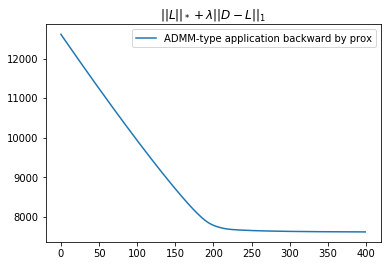

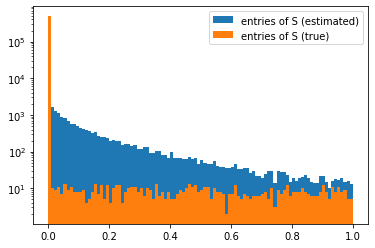

In [4]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6
print('lambda_F = ', le)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ll))
l2loss = lambda x: torch.sum(x**2)

L = 0
S = 0
E = 0
Y = 0

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss_inexact = []
for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

### Robust PCA: $$\textrm{Minimize}_{L}\|L\|_* + \lambda \|D-L\|_1$$
### using auto differentiation


## Alternating-projection-like application of backward by prox
### can find subotptimal solution, clearly identify the nonzeros

D = 
 tensor([[ 0.0778,  1.9967,  2.5257,  ..., -2.6431,  1.9587,  1.0445],
        [ 0.2846,  4.9043,  1.6836,  ...,  0.0712, 10.0185,  2.2327],
        [ 0.9717, -2.8738, -2.6559,  ...,  4.7797, -3.2285,  3.4228],
        ...,
        [ 0.2105, -1.9287, -0.9627,  ..., -0.7004,  1.8635, -0.8568],
        [ 2.3281,  3.5614, -1.7199,  ..., -1.1316, -1.2095, -2.3871],
        [ 3.9198,  0.2734, -4.2799,  ...,  2.3160, -0.5853,  0.8559]],
       device='cuda:0')
[ 40/400]: loss = 11589.5213,  
[ 80/400]: loss = 10524.5037,  
[120/400]: loss = 9505.1547,  
[160/400]: loss = 8556.5188,  
[200/400]: loss = 7840.7762,  
[240/400]: loss = 7700.0211,  
[280/400]: loss = 7673.9948,  
[320/400]: loss = 7661.9396,  
[360/400]: loss = 7655.4977,  
[400/400]: loss = 7651.8382,  
5281.09335899353  [ms]
L = 
 [[ 0.07776086  1.99667033  2.52568892 ... -2.6431012   1.95871215
   1.04446189]
 [ 0.28458009  4.9042761   1.68356404 ...  0.07119743 -1.94421336
   2.23267166]
 [ 0.97165512 -2.87376783 -2.6559

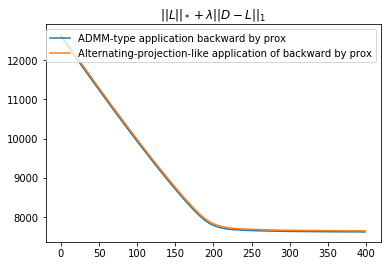

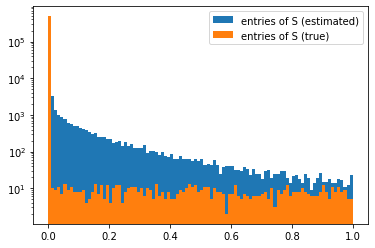

In [5]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ll))
#X = torch.autograd.Variable(D, requires_grad=True)
L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
optimizer = torch.optim.SGD([L], lr = 1e0)

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss_prox = []
for iter in range(num_iter):
    total_loss = 0.
    """
    loss = nucloss(L) + l1loss(D - L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    loss = l1loss(D - L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    #"""

    history_loss_prox.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n',L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="Alternating-projection-like application of backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

## RPCA with alternating gradient descent using autograd
### cannot find sparsify the solution due to the nondifferentiability (see the estimated S), although decrease the loss faster

D = 
 tensor([[ 0.0778,  1.9967,  2.5257,  ..., -2.6431,  1.9587,  1.0445],
        [ 0.2846,  4.9043,  1.6836,  ...,  0.0712, 10.0185,  2.2327],
        [ 0.9717, -2.8738, -2.6559,  ...,  4.7797, -3.2285,  3.4228],
        ...,
        [ 0.2105, -1.9287, -0.9627,  ..., -0.7004,  1.8635, -0.8568],
        [ 2.3281,  3.5614, -1.7199,  ..., -1.1316, -1.2095, -2.3871],
        [ 3.9198,  0.2734, -4.2799,  ...,  2.3160, -0.5853,  0.8559]],
       device='cuda:0')
lambda = 
 0.01
[ 40/400]: loss = 8645.5162,  
[ 80/400]: loss = 8603.9731,  
[120/400]: loss = 8599.1628,  
[160/400]: loss = 8595.9373,  
[200/400]: loss = 8594.1865,  
[240/400]: loss = 8593.4170,  
[280/400]: loss = 8592.1361,  
[320/400]: loss = 8590.2649,  
[360/400]: loss = 8593.0312,  
[400/400]: loss = 8592.4468,  
5315.85693359375  [ms]
L = 
 [[ 0.07776086  1.99667033  2.52568892 ... -2.6431012   1.95871215
   1.04446189]
 [ 0.28458009  4.9042761   1.68356404 ...  0.07119743 -1.94421336
   2.23267166]
 [ 0.97165512 -2.87

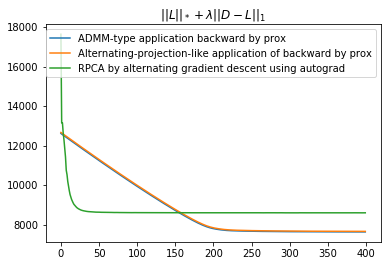

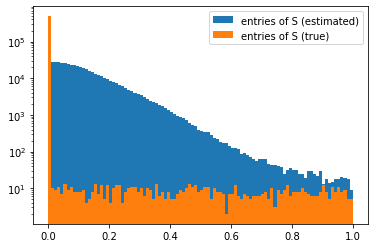

In [6]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ll = 1./np.sqrt(max(m,n))
print('lambda = \n', ll)

nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ll)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
optimizer = torch.optim.Adam([L], lr = 1e0)

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    """
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    loss = l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    #"""

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="Alternating-projection-like application of backward by prox")
plt.plot(history_loss, label="RPCA by alternating gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

## RPCA by gradient descent using autograd
### straightforward use of autograd for RPCA cannot sparsify the solution (see the estimated S).

D = 
 tensor([[ 0.0778,  1.9967,  2.5257,  ..., -2.6431,  1.9587,  1.0445],
        [ 0.2846,  4.9043,  1.6836,  ...,  0.0712, 10.0185,  2.2327],
        [ 0.9717, -2.8738, -2.6559,  ...,  4.7797, -3.2285,  3.4228],
        ...,
        [ 0.2105, -1.9287, -0.9627,  ..., -0.7004,  1.8635, -0.8568],
        [ 2.3281,  3.5614, -1.7199,  ..., -1.1316, -1.2095, -2.3871],
        [ 3.9198,  0.2734, -4.2799,  ...,  2.3160, -0.5853,  0.8559]],
       device='cuda:0')
lambda = 
 0.01
[ 40/400]: loss = 11555.1006,  
[ 80/400]: loss = 10330.0137,  
[120/400]: loss = 9393.5264,  
[160/400]: loss = 8803.8340,  
[200/400]: loss = 8515.2031,  
[240/400]: loss = 8397.5820,  
[280/400]: loss = 8356.4453,  
[320/400]: loss = 8344.7178,  
[360/400]: loss = 8341.3906,  
[400/400]: loss = 8339.6758,  
4965.646743774414  [ms]
L = 
 [[ 0.07776086  1.99667033  2.52568892 ... -2.6431012   1.95871215
   1.04446189]
 [ 0.28458009  4.9042761   1.68356404 ...  0.07119743 -1.94421336
   2.23267166]
 [ 0.97165512 -2

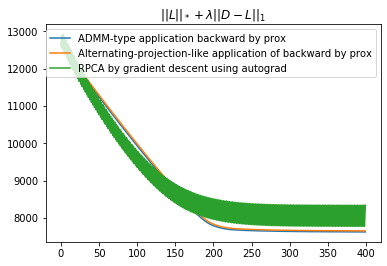

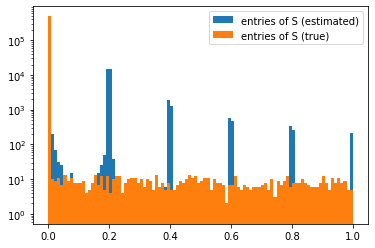

In [7]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ll = 1./np.sqrt(max(m,n))
print('lambda = \n', ll)
le = 1e+6

# Using sum of abs with autogradient
nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ll)
l2loss = lambda x: torch.sum(x**2)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(D, device=device, requires_grad=True)

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    #"""
    #optimizer = torch.optim.SGD([L,S], lr = 1e0)
    #loss = nucloss(L) + l1loss(S) + l2loss((D-L-S)/(1+2*le))

    #optimizer = torch.optim.SGD([L], lr = 1e0)   # SGD works better than Adam
    optimizer = torch.optim.Adam([L], lr = 1e-1)  # Adam would disappoint you
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    optimizer = torch.optim.SGD([L], lr = 1e-1)
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([S], lr = 1e-1)
    loss = l1loss(S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([L,S], lr = 1e-1)
    loss = l2loss(D-L-S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="Alternating-projection-like application of backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()